In [ ]:
!pip install numpy
!pip install river -U
!pip install scikit-learn -U
!pip install seaborn
!pip install matplotlib
!pip install matplotlib-inline
!pip install pandas

In [2]:
from sklearn.decomposition import PCA
from plotly.offline import init_notebook_mode
import clickhouse_connect
import plotly.graph_objs as go
from plotly.offline import iplot
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import time
import plotly.express as px

# K-Means with ClickHouse

The accompanying blog post for this notebook can be found [here]()

We assume the notebook is run sequentially.

## Load data sample

3m NYC taxi rides.

In [3]:
init_notebook_mode(connected=True)
seed = 13
# Modify credentials for clickhouse instance
clickhouse = clickhouse_connect.create_client(host="localhost", username="default",
                                              password="password", database="taxis", secure=False, send_receive_timeout=3000)

In [4]:
clickhouse.query("DROP TABLE IF EXISTS trips")
# create table and insert 3m subset
clickhouse.query("""CREATE TABLE trips (
  trip_id         	UInt32,
  pickup_datetime 	DateTime,
  dropoff_datetime	DateTime,
  pickup_longitude	Nullable(Float64),
  pickup_latitude 	Nullable(Float64),
  dropoff_longitude   Nullable(Float64),
  dropoff_latitude	Nullable(Float64),
  passenger_count 	UInt8,
  trip_distance   	Float32,
  fare_amount     	Float32,
  extra           	Float32,
  tip_amount      	Float32,
  tolls_amount    	Float32,
  total_amount    	Float32,
  payment_type    	Enum('CSH' = 1, 'CRE' = 2, 'NOC' = 3, 'DIS' = 4, 'UNK' = 5),
  pickup_ntaname  	LowCardinality(String),
  dropoff_ntaname 	LowCardinality(String)
)
ENGINE = MergeTree
ORDER BY (pickup_datetime, dropoff_datetime)""")

clickhouse.query("INSERT INTO trips SELECT trip_id, pickup_datetime, dropoff_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, trip_distance, fare_amount, extra, tip_amount, tolls_amount, total_amount, payment_type, pickup_ntaname, dropoff_ntaname FROM gcs('https://storage.googleapis.com/clickhouse-public-datasets/nyc-taxi/trips_{0..2}.gz', 'TabSeparatedWithNames')")

## Initial Data Analysis

In [5]:
# initial data analysis based on a sample of points
df = clickhouse.query_df(
    f"SELECT * EXCEPT payment_type, toUInt8(payment_type) as payment_type FROM trips ORDER BY cityHash64(concat(toString(trip_id), toString({seed}))) ASC LIMIT 10000")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype        
---  ------             --------------  -----        
 0   trip_id            10000 non-null  uint32       
 1   pickup_datetime    10000 non-null  datetime64[s]
 2   dropoff_datetime   10000 non-null  datetime64[s]
 3   pickup_longitude   10000 non-null  float64      
 4   pickup_latitude    10000 non-null  float64      
 5   dropoff_longitude  10000 non-null  float64      
 6   dropoff_latitude   10000 non-null  float64      
 7   passenger_count    10000 non-null  uint8        
 8   trip_distance      10000 non-null  float32      
 9   fare_amount        10000 non-null  float32      
 10  extra              10000 non-null  float32      
 11  tip_amount         10000 non-null  float32      
 12  tolls_amount       10000 non-null  float32      
 13  total_amount       10000 non-null  float32      
 14  pickup_ntaname     1000

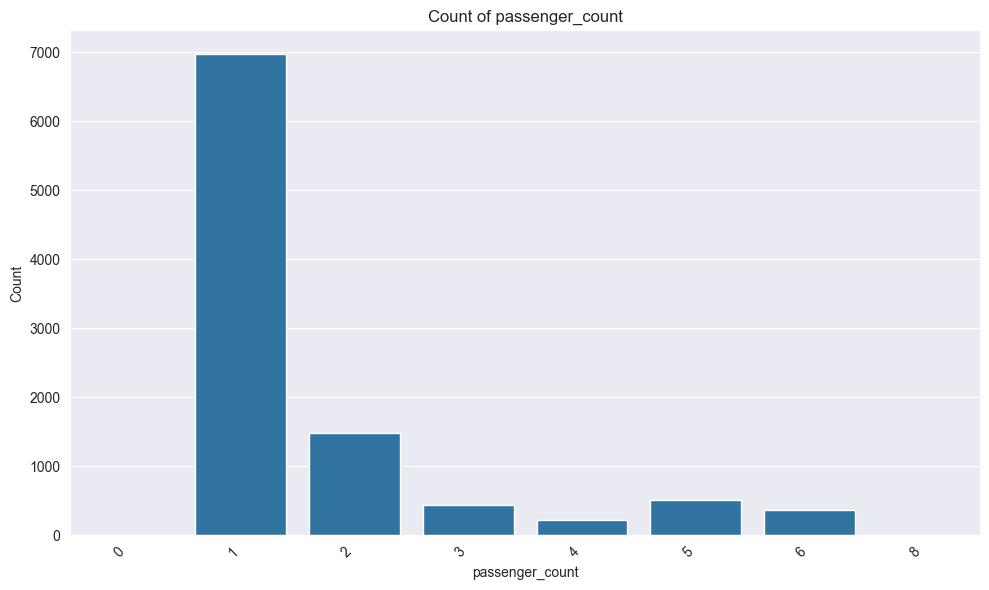

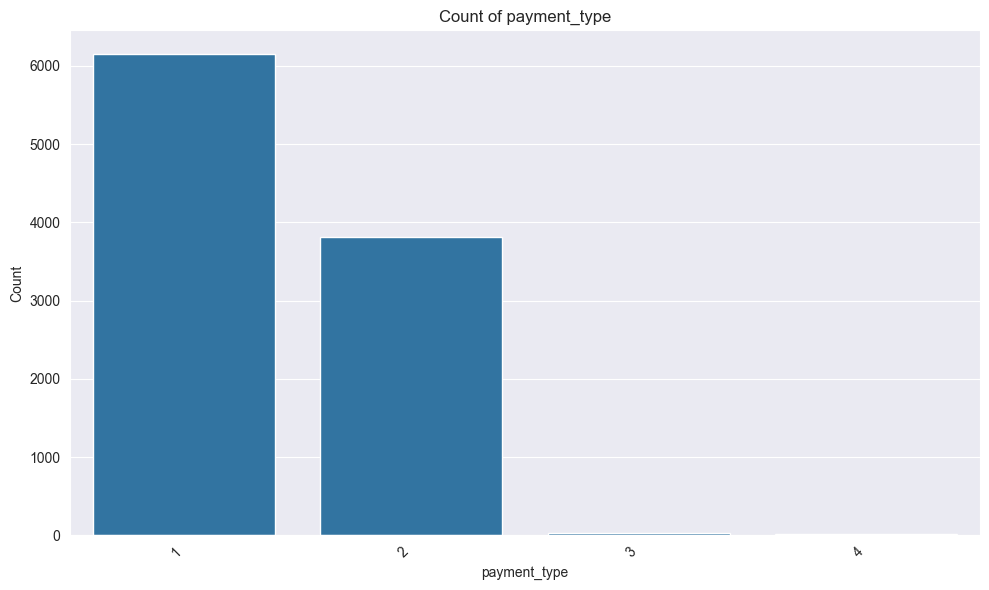

In [6]:
# visualize uint8 columns
uint8_columns = df.select_dtypes(include=['uint8']).columns
for column in uint8_columns:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    ax = sns.countplot(x=column, data=df)
    plt.title(f'Count of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

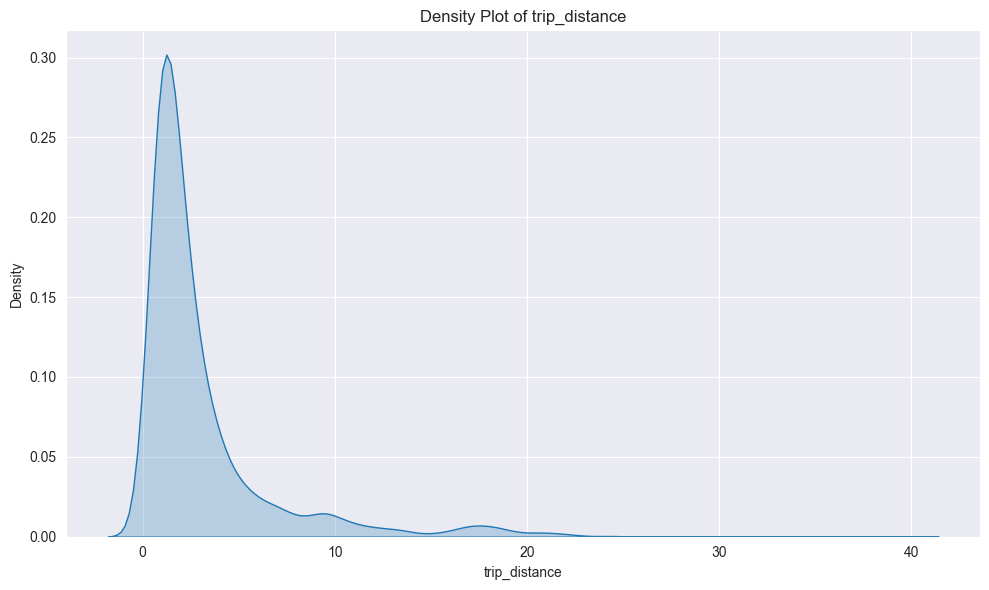

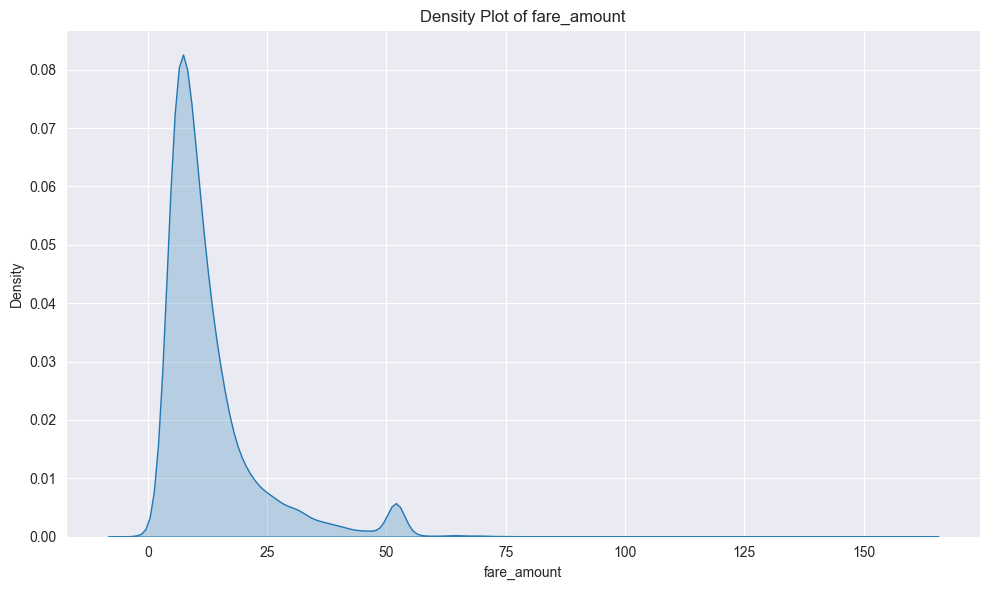

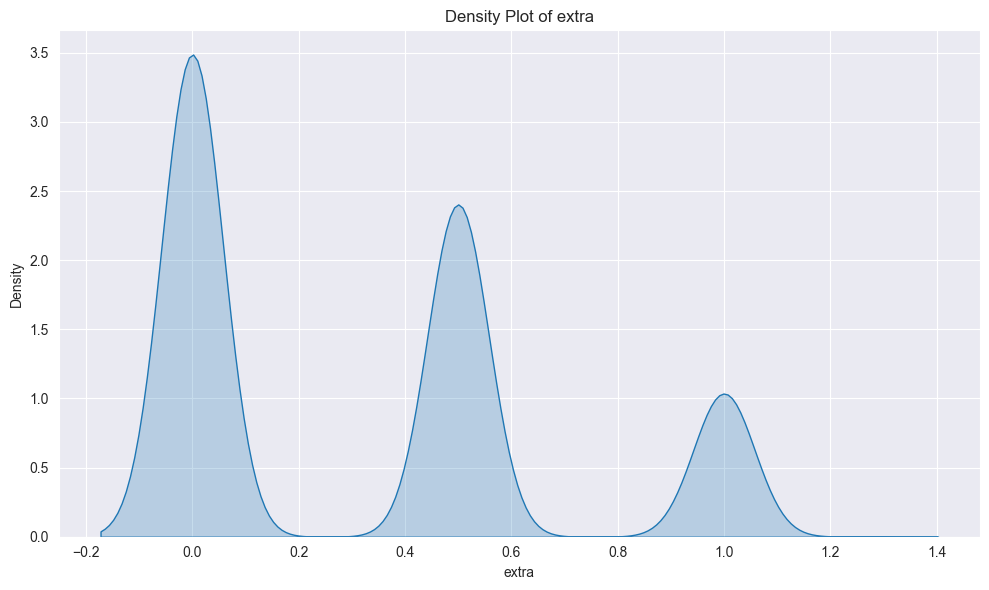

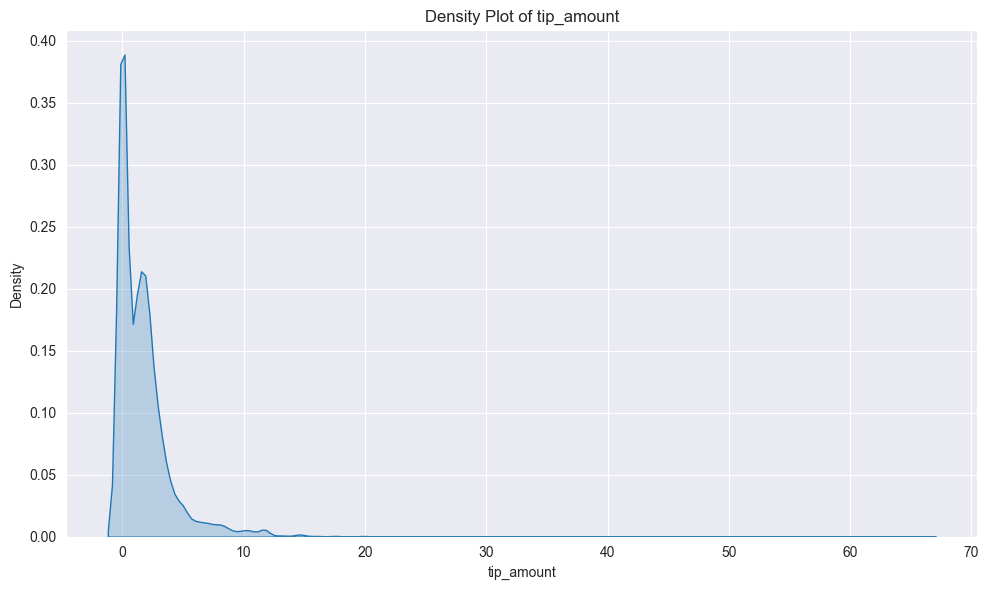

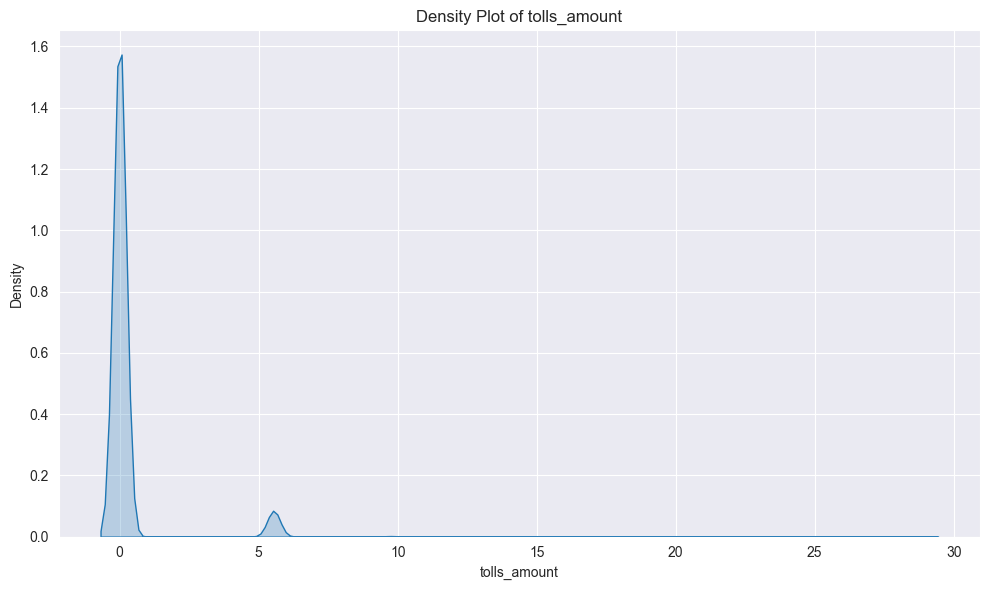

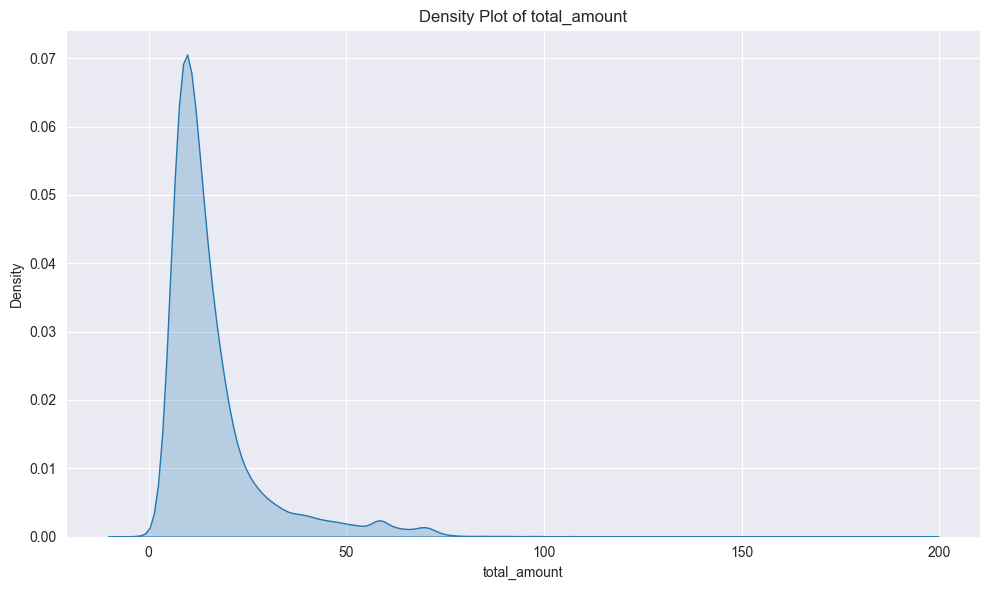

In [7]:
# visualize float32 columns 
float32_columns = df.select_dtypes(include=['float32']).columns
for column in float32_columns:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=column, data=df, fill=True)
    plt.title(f'Density Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

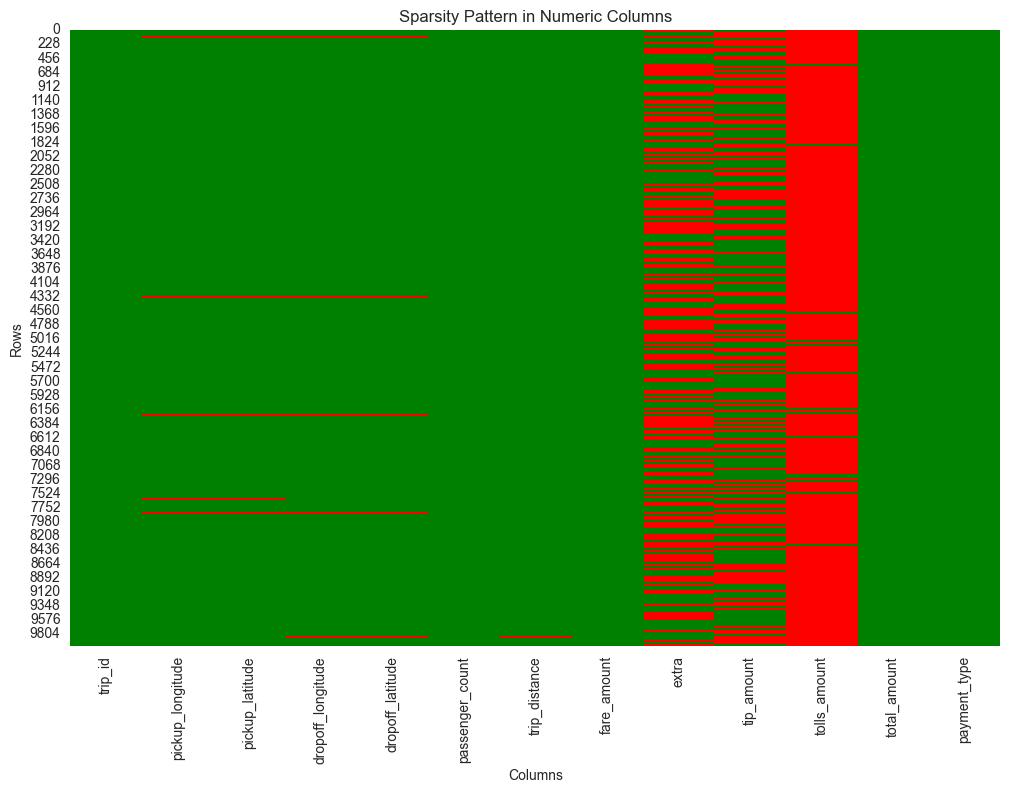

In [8]:
# evaluate sparsity - red is 0s
numeric_df = df.select_dtypes(include=[np.number])
sparse_matrix = numeric_df.copy()
sparse_matrix[sparse_matrix != 0] = np.nan
binary_matrix = (~sparse_matrix.isnull()).astype(int)
cmap = LinearSegmentedColormap.from_list("custom_red_green", ["green", "red"], N=2)
plt.figure(figsize=(12, 8))
sns.heatmap(binary_matrix, cmap=cmap, cbar=False)
plt.title('Sparsity Pattern in Numeric Columns')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

## Feature Engineering

A few observations:

- Rather than using the specific pickup time for a taxi trip, we use features representing the hour, day of the week, and day of the month. These are more likely to cluster vs. a monotonically increasing date time field. Our hope here was to cluster around specific busy periods of the day, week, and month. Our data also covers a period of only three months, so these time buckets make sense versus trying to cluster by seasonality, for example. Note we have a `dropoff_hour` but no `dropoff_day_of_week` or `dropoff_day_of_month`. The latter is redundant and would be linearly correlated with the equivalent pickup features - taxi trips rarely last a whole day, let alone a week!
- We include the pickup and drop-off latitudes and longitudes, hoping to cluster them on geographical locations and specific trip types, such as airport routes. These need to be normalized to avoid dominating the distance calculation.
- The columns `payment_type` and `extra` were discarded. These are categorical variables and aren’t really relevant to a distance-based metric. We could use one-hot encoding or explore other clustering techniques. Still, they are also either sparsely populated (extra) or concentrated on one specific value (payment_type) and thus are of little use.
- While possible we haven’t embedded the pick up and drop off names as vector elements. This information is also encoded in the latitude and longitude. These columns are thus ignored.
- The columns for tip amount and tolls are extremely sparse, with many 0 values. As this will cause its variance, and consequently its impact on the distance calculation, to be significantly lower compared to denser features. This might skew the clustering process, as the algorithm might prioritize minimizing variance in denser features over the sparse ones, potentially overlooking meaningful patterns related to the sparse feature. Additionally, the non-zero tips and tolls could create large distances that might distort the clustering. The values have been added to the fare to address this and produce a `total_amount` column.
- Most columns contain significant outliers e.g. trips with negative distances or invalid coordinates. We filter these out.
- All of the above columns are used to formulate the `vector` column we use in our distance calculation. As part of the process, we need to normalize each value. For this, we replicate the logic of the StandardScalar in Python, subtracting the mean and dividing by the standard deviation of each value.

This leads to the following `points` table containing our features.

In [9]:
def create_points_table(source_table="trips", target_table="points"):
    # select the features we want to use - we omit extra and remove outliers
    clickhouse.query(f"DROP TABLE IF EXISTS {target_table}")
    clickhouse.query(f"""CREATE TABLE {target_table}
    (
        `id` UInt32,
        `vector` Array(Float32),
        `pickup_hour` UInt8,
        `pickup_day_of_week` UInt8,
        `pickup_day_of_month` UInt8,
        `dropoff_hour` UInt8,
        `pickup_longitude` Float64,
        `pickup_latitude` Float64,
        `dropoff_longitude` Float64,
        `dropoff_latitude` Float64,
        `passenger_count` UInt8,
        `trip_distance` Float32,
        `fare_amount` Float32,
        `total_amount` Float32
    ) ENGINE = MergeTree ORDER BY id""")
    # this applies a standard scalar to points
    clickhouse.query(f"""INSERT INTO {target_table}
    WITH (
        -- compute the means and std. devs.
        SELECT map('pickup_hour', [avg(toHour(pickup_datetime)), std(toHour(pickup_datetime))],
         'pickup_day_of_week', [avg(toDayOfWeek(pickup_datetime)), std(toDayOfWeek(pickup_datetime))],
         'pickup_day_of_month', [avg(toDayOfMonth(pickup_datetime)), std(toDayOfWeek(pickup_datetime))],
         'dropoff_hour', [avg(toHour(dropoff_datetime)), std(toHour(dropoff_datetime))],
         'pickup_longitude', [avg(pickup_longitude), std(pickup_longitude)],
         'pickup_latitude', [avg(pickup_latitude), std(pickup_latitude)],
         'dropoff_longitude', [avg(dropoff_longitude), std(dropoff_longitude)],
         'dropoff_latitude', [avg(dropoff_latitude), std(dropoff_latitude)],
         'passenger_count', [avg(passenger_count), std(passenger_count)],
         'trip_distance', [avg(trip_distance), std(trip_distance)],
         'fare_amount', [avg(fare_amount), std(fare_amount)],
         'total_amount', [avg(tip_amount+fare_amount+tolls_amount), std(tip_amount+fare_amount+tolls_amount)])
         FROM {source_table}
            -- filter out outliers for mean and std. dev. calculations
            WHERE fare_amount > 0 AND trip_distance > 0 AND round(pickup_longitude) BETWEEN -75 AND -73 AND round(pickup_latitude) BETWEEN 39 AND 41 AND round(dropoff_longitude) BETWEEN -75 AND -73 AND round(dropoff_latitude) BETWEEN 39 AND 41 AND tolls_amount >= 0 AND tip_amount >= 0
        ) AS scalars
    SELECT
        trip_id as id,
        -- produce the vector by scaling each variable
        [(toHour(pickup_datetime) - scalars['pickup_hour'][1]) / scalars['pickup_hour'][2],
        (toDayOfWeek(pickup_datetime) - scalars['pickup_day_of_week'][1]) / scalars['pickup_day_of_week'][2],
        (toDayOfMonth(pickup_datetime) - scalars['pickup_day_of_month'][1]) / scalars['pickup_day_of_month'][2],
        (toHour(dropoff_datetime) - scalars['dropoff_hour'][1]) / scalars['dropoff_hour'][2],
        (pickup_longitude - scalars['pickup_longitude'][1]) / scalars['pickup_longitude'][2],
        (pickup_latitude - scalars['pickup_latitude'][1]) / scalars['pickup_latitude'][2],
        (dropoff_longitude - scalars['dropoff_longitude'][1]) / scalars['dropoff_longitude'][2],
        (dropoff_latitude - scalars['dropoff_latitude'][1]) / scalars['dropoff_latitude'][2],
        (passenger_count - scalars['passenger_count'][1]) / scalars['passenger_count'][2],
        (trip_distance - scalars['trip_distance'][1]) / scalars['trip_distance'][2],
        (fare_amount - scalars['fare_amount'][1]) / scalars['fare_amount'][2],
        ((tip_amount+fare_amount+tolls_amount) - scalars['total_amount'][1]) / scalars['total_amount'][2]],
        -- provide features unscaled
        toHour(pickup_datetime) AS pickup_hour,
        toDayOfWeek(pickup_datetime) AS pickup_day_of_week,  
        toDayOfMonth(pickup_datetime) AS pickup_day_of_month,
        toHour(dropoff_datetime) AS dropoff_hour,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        passenger_count,
        trip_distance,
        fare_amount,
        fare_amount+tip_amount+tolls_amount AS total_amount
    FROM {source_table}
    -- filter out outliers
    WHERE fare_amount > 0 AND trip_distance > 0 AND round(pickup_longitude) BETWEEN -75 AND -73 AND round(pickup_latitude) BETWEEN 39 AND 41 AND round(dropoff_longitude) BETWEEN -75 AND -73 AND round(dropoff_latitude) BETWEEN 39 AND 41 AND tolls_amount >= 0 AND tip_amount >= 0""")

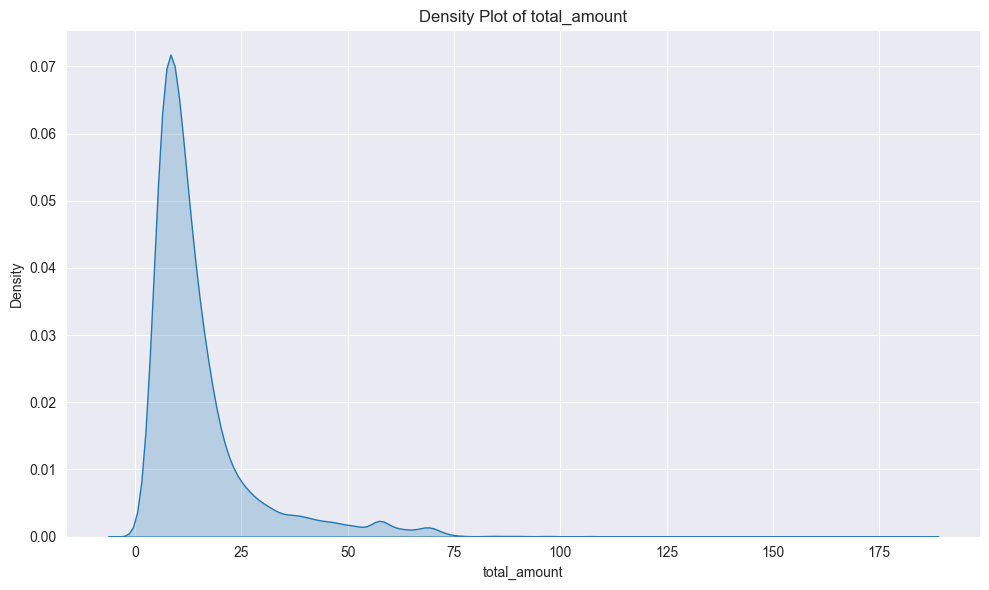

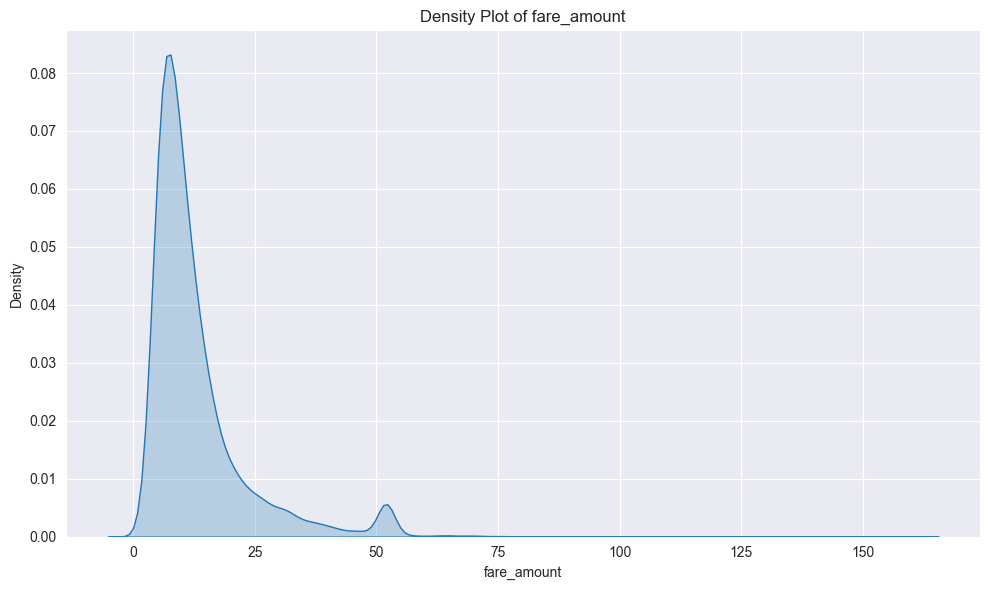

In [11]:
# create our points table on which we will cluster uses the above feature scaling
create_points_table(source_table="trips", target_table="points")
# Check the new distributions of float32
df = clickhouse.query_df(f"SELECT total_amount, fare_amount FROM points ORDER BY cityHash64(concat(toString(id), toString({seed}))) ASC LIMIT 10000")
float32_columns = df.select_dtypes(include=['float32']).columns
for column in float32_columns:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=column, data=df, fill=True)
    plt.title(f'Density Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

## K-Means with ClickHouse

In [12]:
# method to initialize supporting table for K-Means
def create_kmeans_tables():
    # create our supporting tables for K-Means
    clickhouse.query("DROP TABLE IF EXISTS temp")
    clickhouse.query(f"DROP TABLE IF EXISTS centroids")
    clickhouse.query(f"DROP TABLE IF EXISTS centroids_mv")
    
    clickhouse.query("""
    CREATE TABLE temp
    (
        `k` UInt32,
        `iteration` UInt32,
        `centroid` UInt32,
        `v` Array(Float32)
    )
    ENGINE = Null
    """)
    clickhouse.query(f"""
        CREATE MATERIALIZED VIEW centroids_mv TO centroids
        AS 
        SELECT k, iteration, centroid, avgForEachState(v) AS vector
        FROM temp GROUP BY k, centroid, iteration
    """)
    clickhouse.query(f"""
    CREATE TABLE centroids
    (
        `k` UInt32,
        `iteration` UInt32,
        `centroid` UInt32,
        `vector` AggregateFunction(avgForEach, Array(Float32))
    )
    ENGINE = AggregatingMergeTree
    ORDER BY (k, iteration, centroid)
    """)

In [13]:
# Performs K-Means for value of k. Assume points are in source_table. Stops once the number of points which move clusters < min_cluster_move. This check is made every report_every
def kmeans(k, report_every = 5, min_cluster_move = 1000, source_table="points"):
    start_time = time.time()
    print(f"k={k}")
    # initialize the centroids
    print("initializing...", end="")
    clickhouse.query(f"""
    INSERT INTO temp WITH vectors AS
        (
            SELECT vector AS v
            FROM {source_table}
            ORDER BY cityHash64(concat(toString(id), toString({k}))) ASC
            LIMIT {k}
        )
    SELECT
        {k} as k,
        1 AS iteration,
        rowNumberInAllBlocks() AS centroid,
        *
    FROM vectors""")
    print("OK")
    i = 0
    print("Iteration ", end="")
    while True:
        # perform an interation
        print(f"{i}", flush=True, end="")
        clickhouse.query(f"""
            INSERT INTO temp WITH
                (
                    SELECT max(iteration)
                    FROM centroids WHERE k={k}
                ) AS c_iteration,
                (
                    SELECT groupArray((centroid, position))
                    FROM
                    (
                        SELECT
                            centroid,
                            avgForEachMerge(vector) AS position
                        FROM centroids
                        WHERE iteration = c_iteration AND k={k}
                        GROUP BY centroid
                    )
                ) AS c_centroids
            SELECT
                {k} as k,
                c_iteration + 1 AS iteration,
                (arraySort(c -> (c.2), arrayMap(x -> (x.1, L2Distance(x.2, vector)), c_centroids))[1]).1 AS centroid,
                vector AS v
            FROM {source_table}
        """)
        if (i + 1) % report_every == 0 or i == 0:
            print()
            # identify the number of points which have moved clusters
            response = clickhouse.query(f"""
                WITH (
                    SELECT max(iteration)
                    FROM centroids WHERE k={k}
                ) AS c_iteration,
                (
                    SELECT groupArray((centroid, position))
                    FROM
                    (
                        SELECT
                            centroid,
                            avgForEachMerge(vector) AS position
                        FROM centroids
                        WHERE iteration = c_iteration AND k={k}
                        GROUP BY centroid
                    )
                ) AS c_centroids,
                (
                    SELECT groupArray((centroid, position))
                    FROM
                    (
                        SELECT
                            centroid,
                            avgForEachMerge(vector) AS position
                        FROM centroids
                        WHERE iteration = (c_iteration-1) AND k={k}
                        GROUP BY centroid
                    )
                ) AS c_i_centroids
                SELECT sum(changed) FROM (
                    SELECT id, 
                    (arraySort(c -> (c.2), arrayMap(x -> (x.1, L2Distance(x.2, vector)), c_centroids))[1]).1 AS cluster,
                    (arraySort(c -> (c.2), arrayMap(x -> (x.1, L2Distance(x.2, vector)), c_i_centroids))[1]).1 AS cluster_i,
                    if(cluster = cluster_i, 0, 1) as changed
                    FROM {source_table}
                )
                """)
            print(
                f"Number changed cluster in {'first iteration' if i == 0 else f'iteration {i + 1}'}: {response.first_row[0]}",
                flush=True)
            if int(response.first_row[0]) <= min_cluster_move:
                print(f"stopping as moved less than {min_cluster_move} clusters in last iteration")
                break
            print("Iteration ", end="")
        else:
            print(f", ", flush=True, end="")
        i += 1
    execution_time = (time.time() - start_time)
    print('Execution time in seconds: ' + str(execution_time))
    # compute final d^2
    response = clickhouse.query(f"""
        WITH (
                SELECT max(iteration)
                FROM centroids WHERE k={k}
        ) AS c_iteration,
        (
            SELECT groupArray((centroid, position))
            FROM
            (
                SELECT
                    centroid,
                    avgForEachMerge(vector) AS position
                FROM centroids
                WHERE iteration = c_iteration AND k={k}
                GROUP BY centroid
            )
        ) AS c_centroids
        SELECT
            sum(pow((arraySort(c -> (c.2), arrayMap(x -> (x.1, L2Distance(x.2, vector)), c_centroids))[1]).2, 2)) AS distance
        FROM {source_table}
        """)
    print(f"D^2 error for {k}: {response.first_row[0]}", flush=True)
    # return the d^2, execution time and num of required iterations
    return response.first_row[0], execution_time, i+1

In [14]:
# initialize supporting tables
create_kmeans_tables()
# k values to evaluate
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20]
# this will store our results
results = []
# run K-Means for the values of K. This can take sometime depending on the number of values selected and the cluster size.
for k in ks:
    d_2, execution_time, iterations = kmeans(k, report_every = 5, min_cluster_move = 1000)
    results.append([k, d_2, execution_time, iterations])

k=2
initializing...OK
Iteration 0
Number changed cluster in first iteration: 45637
Iteration 1, 2, 3, 4
Number changed cluster in iteration 5: 0
stopping as moved less than 1000 clusters in last iteration
Execution time in seconds: 3.432060956954956
D^2 error for 2: 47210270.32900806
k=3
initializing...OK
Iteration 0
Number changed cluster in first iteration: 289585
Iteration 1, 2, 3, 4
Number changed cluster in iteration 5: 0
stopping as moved less than 1000 clusters in last iteration
Execution time in seconds: 3.3356211185455322
D^2 error for 3: 38951868.631498806
k=4
initializing...OK
Iteration 0
Number changed cluster in first iteration: 809752
Iteration 1, 2, 3, 4
Number changed cluster in iteration 5: 7794
Iteration 5, 6, 7, 8, 9
Number changed cluster in iteration 10: 0
stopping as moved less than 1000 clusters in last iteration
Execution time in seconds: 6.076797008514404
D^2 error for 4: 35977692.15147461
k=5
initializing...OK
Iteration 0
Number changed cluster in first iterat

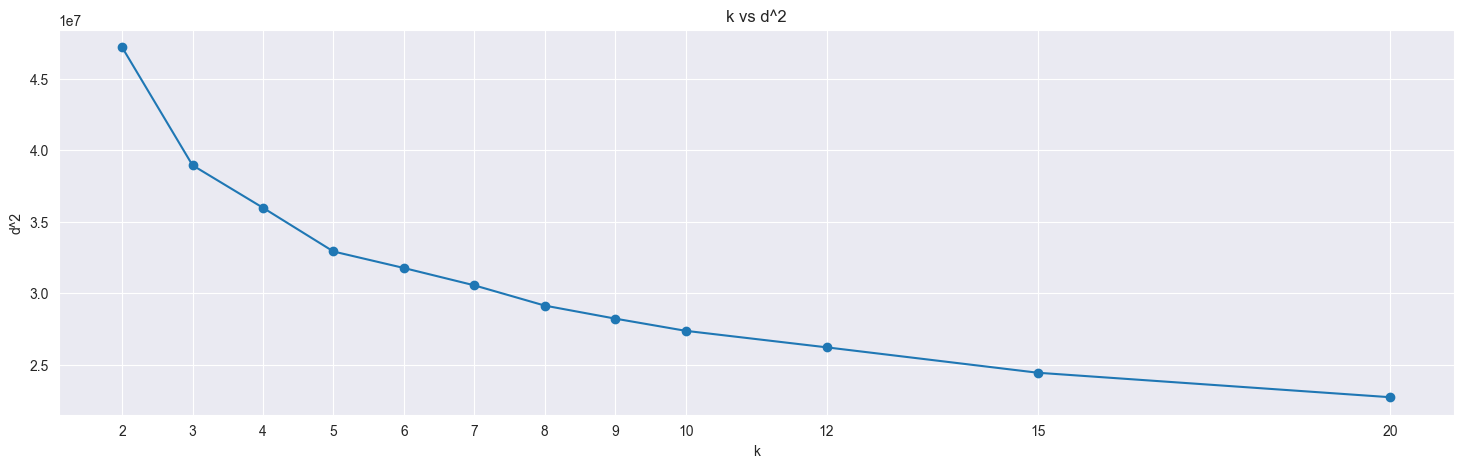

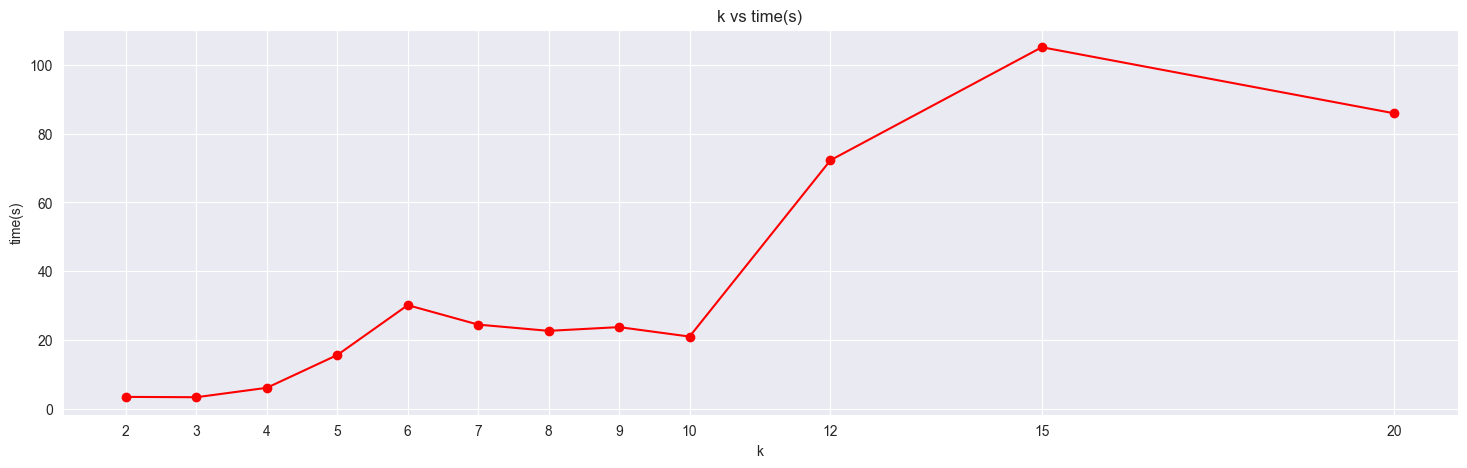

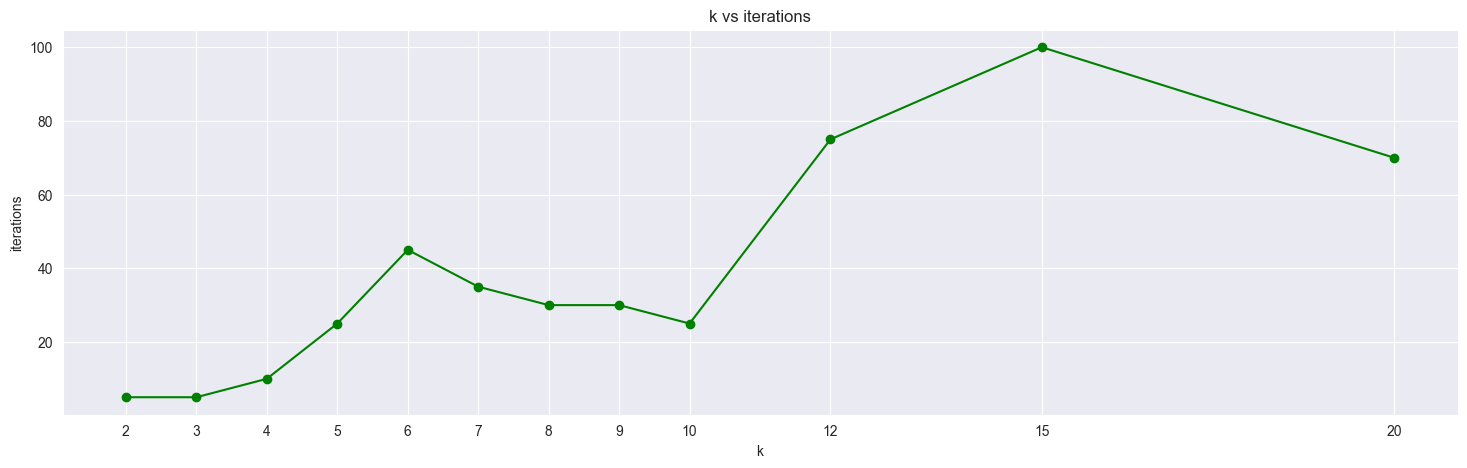

In [15]:
# View the error, time taken and number of iterations required per value of K
df = pd.DataFrame(results, columns=['k', 'd^2', 'time(s)', 'iterations'])
# Plot 1: k vs d^2
plt.figure(figsize=(18, 5))
plt.plot(df['k'], df['d^2'], marker='o')
plt.title('k vs d^2')
plt.xlabel('k')
plt.ylabel('d^2')
plt.xticks(df['k'].unique())  # Set x-axis ticks to only show integers
plt.show() 

# Plot 2: k vs time(s)
plt.figure(figsize=(18, 5))
plt.plot(df['k'], df['time(s)'], marker='o', color='red')
plt.title('k vs time(s)')
plt.xlabel('k')
plt.ylabel('time(s)')
plt.xticks(df['k'].unique())  # Set x-axis ticks to only show integers
plt.show()

# Plot 3: k vs iterations
plt.figure(figsize=(18, 5)) 
plt.plot(df['k'], df['iterations'], marker='o', color='green')
plt.title('k vs iterations')
plt.xlabel('k')
plt.ylabel('iterations')
plt.xticks(df['k'].unique())  # Set x-axis ticks to only show integers
plt.show()

## Visualizing Clusters

In [16]:
# retrieve n random points with associated clusters
def get_random_points_with_clusters(k, n=10000, source_table="points"):
    results = clickhouse.query_df(f"""
        WITH (
                SELECT max(iteration)
                FROM centroids WHERE k = {k}
        ) AS c_iteration,
        (
            SELECT groupArray((centroid, position))
            FROM
            (
                SELECT
                    centroid,
                    avgForEachMerge(vector) AS position
                FROM centroids
                WHERE iteration = c_iteration AND k = {k}
                GROUP BY centroid
            )
        ) AS c_centroids
        SELECT
            id,
            vector,
            (arraySort(c -> (c.2), arrayMap(x -> (x.1, L2Distance(x.2, vector)), c_centroids))[1]).1 AS cluster,
            *
        FROM {source_table} ORDER BY cityHash64(concat(toString(id), toString({k}))) ASC
        LIMIT {n}
    """)
    # ensure we sample all clusters
    assert len(results['cluster'].unique().tolist()) == k
    return results

In [17]:
# select k based on the above scree plot
k = 5
n = 10000
results = get_random_points_with_clusters(k, n)
# Run PCA with three principal components
pca_3d = PCA(n_components=3, random_state=seed)
PCs_3d = pd.DataFrame(pca_3d.fit_transform(results["vector"].tolist()))
print(f"Explained variances of the 3 principal components: {round(np.cumsum(pca_3d.explained_variance_ratio_)[-1], 3)}")
init_notebook_mode(connected=True)
PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]
# identify cluster labels
components_3d = pca_3d.components_
# For the 3D PCA, print the indexes of the features contributing most to each component
key_features = set()
column_names = ["pickup_hour", "pickup_day_of_week", "pickup_day_of_month", "dropoff_hour", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "passenger_count", "trip_distance", "fare_amount", "total_amount"]
# Identify main contributing vector dimensions per PCA component
for i, component in enumerate(components_3d):
    # Sort the components by their absolute values in descending order
    feature_indexes = abs(component).argsort()[::-1]  # Use abs(component) to sort by absolute values
    feature_weights = component[feature_indexes]
    # Ensure the correct indexes are used to match column names and their weights
    key_column_names = [f"{column_names[index]}: {feature_weights[j]}" for j, index in enumerate(feature_indexes)]
    print(f"PCA {i + 1}:: {key_column_names}")

Explained variances of the 3 principal components: 0.82


PCA 1:: ['pickup_day_of_month: 0.9999702812441758', 'passenger_count: 0.004252708942050269', 'total_amount: 0.0039345891984293785', 'fare_amount: 0.003497076401464287', 'dropoff_longitude: 0.002441606244147553', 'pickup_latitude: 0.0017000993332893259', 'pickup_longitude: 0.0015998563216565603', 'dropoff_hour: 0.0011283950235139518', 'pickup_day_of_week: 0.0009400587527671689', 'pickup_hour: -0.00019895915823171933', 'dropoff_latitude: 0.00018033119690797082', 'trip_distance: 1.2274408305722774e-05']
PCA 2:: ['total_amount: 0.5766941967116377', 'fare_amount: 0.5691262749655578', 'pickup_longitude: 0.41419332529183833', 'pickup_latitude: -0.2812676207335304', 'dropoff_longitude: 0.24869988750860814', 'dropoff_latitude: -0.16723350980097662', 'dropoff_hour: -0.04336205616080349', 'pickup_hour: -0.03334589832773817', 'pickup_day_of_month: -0.004986902915128444', 'pickup_day_of_week: 0.0030849679411099986', 'trip_distance: 0.002165964564171256', 'passenger_count: 0.0012353567247506256']
PC

In [18]:
# plot the clusters in 3 dimensions
def plot_clusters_3d(results):
    c_ids = results['cluster'].unique().tolist()
    clusters_3d = []
    # Choose a colormap
    cmap = matplotlib.colormaps.get_cmap('viridis')
    # Generate colors from the colormap
    colors = [cmap(i / k) for i in range(k)]
    colors_hex = [matplotlib.colors.rgb2hex(colors[i][:3]) for i in range(k)]
    for c in c_ids:
        cluster = results[results["cluster"] == c]
        color = colors_hex[c % len(colors)]
        clusters_3d.append(go.Scatter3d(
            x=cluster["PC1_3d"],
            y=cluster["PC2_3d"],
            z=cluster["PC3_3d"],
            marker=dict(color=color),
            mode="markers",
            name=f"Cluster {c}",
            text=None))
    title = "Visualizing Clusters in Three Dimensions Using PCA"
    # Adjust the layout for 3D
    layout = dict(title=title,
                  width=1600,  # Specify the width of the figure
                  height=1200,  # Specify the height of the figure
                  scene=dict(
                      xaxis=dict(title='PC1', ticklen=5, zeroline=False),
                      yaxis=dict(title='PC2', ticklen=5, zeroline=False),
                      zaxis=dict(title='PC3', ticklen=5, zeroline=False),
                  )
                  )
    fig = go.Figure(data=clusters_3d, layout=layout)
    iplot(fig)

In [19]:
results = pd.concat([results.reset_index(drop=True), PCs_3d], axis=1, join='inner')
plot_clusters_3d(results)

In [20]:
# visualize clusters on a map
# IMPORTANT: Change this to match the cluster which is separate from the rest
taxi_cluster = 0
# Filter the results dataframe to include only rows where the cluster is 3
cluster_taxis_data = results[results['cluster'] == taxi_cluster]
# Create two dataframes: one for pickup points and one for dropoff points
pickup_data = cluster_taxis_data[['pickup_latitude', 'pickup_longitude']].copy()
pickup_data['Type'] = 'Pickup'
dropoff_data = cluster_taxis_data[['dropoff_latitude', 'dropoff_longitude']].copy()
dropoff_data.rename(columns={'dropoff_latitude': 'pickup_latitude', 'dropoff_longitude': 'pickup_longitude'}, inplace=True)
dropoff_data['Type'] = 'Dropoff'

# Combine the dataframes
combined_data = pd.concat([pickup_data, dropoff_data])

# Plot using the combined dataframe
fig = px.scatter_mapbox(combined_data,
                        lat="pickup_latitude",
                        lon="pickup_longitude",
                        color="Type",  # Differentiate between Pickup and Dropoff
                        zoom=11,
                        height=800,
                        # Removed the width parameter to allow full width
                        )

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

## Larger K-Means sample

In [21]:
# Full dataset example - This takes longer to run as it loads 4.6GB with 170m (170,896,055) rows. Takes 3 mins on 60 core node.
clickhouse.query("DROP TABLE IF EXISTS trips_full")
clickhouse.query("""CREATE TABLE trips_full
(
    `trip_id` UInt32,
    `pickup_datetime` DateTime,
    `dropoff_datetime` DateTime,
    `pickup_longitude` Float64,
    `pickup_latitude` Float64,
    `dropoff_longitude` Float64,
    `dropoff_latitude` Float64,
    `passenger_count` UInt8,
    `trip_distance` Float32,
    `fare_amount` Float32,
    `extra` Float32,
    `tip_amount` Float32,
    `tolls_amount` Float32,
    `total_amount` Float32
)
ENGINE = MergeTree
ORDER BY (pickup_datetime, dropoff_datetime)""")

clickhouse.query("INSERT INTO trips_full SELECT * FROM s3('https://datasets-documentation.s3.eu-west-3.amazonaws.com/nyc-taxi/trips_2019.parquet')")

In [22]:
# create a larger points table - again copies 170m rows. Post filtering we have 167,460,937. 2mins on 60 cores.
create_points_table(source_table="trips_full", target_table="points_full")

In [ ]:
k = 5
create_kmeans_tables()
d_2, execution_time, iterations = kmeans(k, report_every = 5, min_cluster_move = 1000, source_table="points_full")
print(f"Completed in {execution_time}s and {iterations} iterations with error {d_2}")

k=5
initializing...OK
Iteration 0
Number changed cluster in first iteration: 28797435
Iteration 1, 2, 3, 4
Number changed cluster in iteration 5: 5286891
Iteration 5, 6, 7, 8, 9
Number changed cluster in iteration 10: 45251
Iteration 10, 11, 12, 13, 14
Number changed cluster in iteration 15: 3501
Iteration 15, 16, 17

In [25]:
full_results = get_random_points_with_clusters(k, n=10000, source_table="points_full")

In [26]:
#PCA with three principal components
pca_3d = PCA(n_components=3, random_state=seed)
PCs_3d = pd.DataFrame(pca_3d.fit_transform(full_results["vector"].tolist()))
print(f"Explained variances of the 3 principal components: {round(np.cumsum(pca_3d.explained_variance_ratio_)[-1], 3)}")
init_notebook_mode(connected=True)
PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]
results_reset = full_results.reset_index(drop=True)
plot_clusters_3d(pd.concat([results_reset, PCs_3d], axis=1, join='inner'))

Explained variances of the 3 principal components: 0.822
